In [1]:
from __future__ import division, print_function
import numpy as np
from scipy import interpolate,integrate,fftpack
import pyfits
import plotc
import read_params
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy.special import j1,j0,jn
def j2(z): return jn(2,z)
def j1prime(z): return 0.5*(j0(z)-j2(z))
import os,shutil,fnmatch
import dbyd2
%matplotlib inline

Lx = read_params.get_xlength()
nx = read_params.get_nx()
x = np.linspace(-Lx/2,Lx/2,nx,endpoint=False);dx=x[1]-x[0]
Rsun=6.95989467700E2
z,c_sound,rho = np.loadtxt(read_params.get_solarmodel(),usecols=[0,1,2],unpack=True); z=(z-1)*Rsun;c_sound/=100;

def ddz(z_profile):
    darr = dbyd2.dbyd2(np.asfortranarray(np.atleast_2d(z_profile)),1)
    dz2d = dbyd2.dbyd2(np.asfortranarray(np.atleast_2d(z)),1)
    return np.squeeze(darr/dz2d)

def fitsread(f): return np.squeeze(pyfits.getdata(f))

In [2]:
datadir_list = [os.path.join(os.path.dirname(read_params.get_directory()),
                             "spline_SG{:d}".format(sgno)) for sgno in xrange(1,5)]

home = os.environ["HOME"]
codedir_list = [os.path.join(home,"sparc_SG{:d}".format(sgno)) for sgno in xrange(1,5)]

## Fitted models

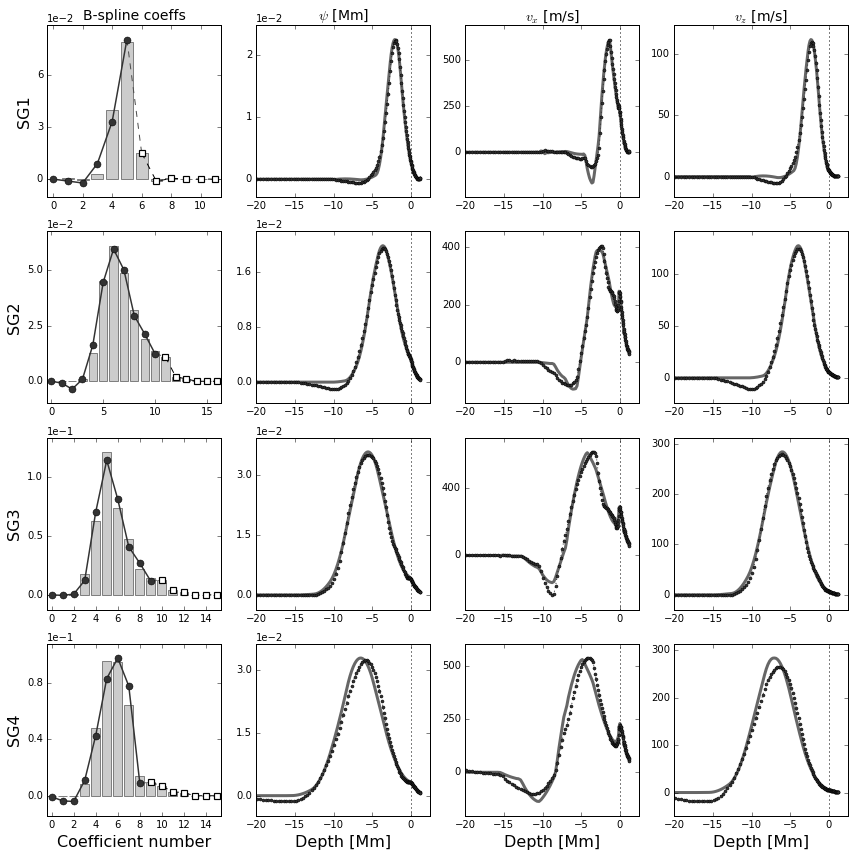

In [90]:
f=plt.figure()
f.set_size_inches(12,12);

for modelno,(codedir,datadir) in enumerate(zip(codedir_list,datadir_list)):
    
    plt.subplot(len(datadir_list),4,modelno*len(datadir_list)+1)

    coeff_files = sorted(fnmatch.filter(os.listdir(os.path.join(datadir,"update")),
                    "model_psi_[0-9][0-9]_coeffs.npz"))

    spline_basis_coeffs = [np.load(os.path.join(datadir,"update",f)) for f in coeff_files]
    spline_basis_z = [s["z"] for s in spline_basis_coeffs]

    true_coeffs = np.load(os.path.join(datadir,"true_psi_coeffs.npz"))
    true_coeffs_z = true_coeffs["cz_bot"]
    true_coeffs_top = true_coeffs["cz_top"]
    c_surf_cutoff = true_coeffs['c_surf_cutoff']

    iterno = len(spline_basis_z)-1

    plt.plot(spline_basis_z[iterno][:c_surf_cutoff],ls="solid",
    marker="o",markersize=7,label="Iterated",
    color="0.2",lw=1.5,zorder=4)

    bridge = [spline_basis_z[iterno][c_surf_cutoff-1],true_coeffs_top[c_surf_cutoff]]

    plt.plot(np.arange(c_surf_cutoff-1,c_surf_cutoff+1),
    bridge,ls="dashed",color='0.3',lw=1,zorder=3)

    plt.plot(np.arange(c_surf_cutoff,true_coeffs_top.size),
    true_coeffs_top[c_surf_cutoff:],ls="dashed",marker='s',ms=6,color='black',
    mec='black',mfc="white",lw=1,zorder=3,mew=1.2,
    label="Clamped")

    plt.gca().margins(y=0.1)

    plt.bar(np.arange(true_coeffs_z.size)-0.4,true_coeffs_z+true_coeffs_top,width=0.8,
            facecolor="0.8",edgecolor="0.5",label="Reference"
            ,zorder=1)   
    
    plt.ticklabel_format(axis="y",style="sci",scilimits=(0,0))
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
    
    # psi and v sections
    
    true_psi = fitsread(os.path.join(codedir,'true_psi.fits'))
    current_psi = fitsread(os.path.join(datadir,'update',
                    'model_psi_{:02d}.fits'.format(iterno)))
    current_psi = current_psi-current_psi[0,0]

    true_vx = fitsread(os.path.join(codedir,'true_vx.fits'))
    true_vz = fitsread(os.path.join(codedir,'true_vz.fits'))

    current_vx = fitsread(
    os.path.join(datadir,'update','vx_{:02d}.fits'.format(iterno)))

    current_vz = fitsread(
    os.path.join(datadir,'update','vz_{:02d}.fits'.format(iterno)))
    
    psi_max_row_index,psi_max_col_index = divmod(true_psi.argmax(),nx)
    curpsi_max_row_index,curpsi_max_col_index = divmod(current_psi.argmax(),nx)

    vx_max_row_index,vx_max_col_index = divmod(true_vx.argmax(),nx)
    curvx_max_row_index,curvx_max_col_index = divmod(current_vx.argmax(),nx)

    vz_max_row_index,vz_max_col_index = divmod(true_vz.argmax(),nx)
    curvz_max_row_index,curvz_max_col_index = divmod(current_vz.argmax(),nx)

    ref_color="0.4"
    iter_color="0.2"
    
    plt.subplot(len(datadir_list),4,modelno*len(datadir_list)+2)
    plt.plot(z,true_psi[:,curpsi_max_col_index],label="Reference",
             color=ref_color,linewidth=3)
    plt.plot(z,current_psi[:,curpsi_max_col_index],label="Iterated",
    linewidth=1,color=iter_color,ls="dotted",marker='o',ms=3)
    plt.ticklabel_format(axis="y",style="sci",scilimits=(0,0))
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
    plt.axvline(0,ls="dotted",color="black")
    plt.xlim(-20,2.5)        
    plt.margins(y=0.1)

    plt.subplot(len(datadir_list),4,modelno*len(datadir_list)+3)
    plt.plot(z,true_vx[:,curvx_max_col_index],label="Reference",
             color=ref_color,linewidth=3)
    plt.plot(z,current_vx[:,curvx_max_col_index],label="Iterated",
    linewidth=1,color=iter_color,ls="dotted",marker='o',ms=3)
    plt.axvline(0,ls="dotted",color="black")
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
    plt.xlim(-20,2.5)
    plt.margins(y=0.1)

    plt.subplot(len(datadir_list),4,modelno*len(datadir_list)+4)
    plt.plot(z,true_vz[:,curvz_max_col_index],label="Reference",
             color=ref_color,linewidth=3)
    plt.plot(z,current_vz[:,curvz_max_col_index],label="Iterated",
    linewidth=1,color=iter_color,ls="dotted",marker='o',ms=3)
    plt.axvline(0,ls="dotted",color="black")
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
    plt.xlim(-20,2.5)
    plt.margins(y=0.1)
    

plt.subplot(len(datadir_list),4,1)
plt.title("B-spline coeffs",fontsize=14)

for modelno,datadir in enumerate(datadir_list):
    plt.subplot(len(datadir_list),4,4*modelno+1)
    plt.ylabel(os.path.basename(datadir).replace("spline_",""),fontsize=16)

plt.subplot(len(datadir_list),4,2)
plt.title(r"$\psi$ [Mm]",fontsize=14)

plt.subplot(len(datadir_list),4,3)
plt.title(r"$v_x$ [m/s]",fontsize=14)

plt.subplot(len(datadir_list),4,4)
plt.title(r"$v_z$ [m/s]",fontsize=14)

plt.subplot(len(datadir_list),4,4*(len(datadir_list)-1)+1)
plt.xlabel("Coefficient number",fontsize=16)

plt.subplot(len(datadir_list),4,4*(len(datadir_list)-1)+2)
plt.xlabel("Depth [Mm]",fontsize=16)

plt.subplot(len(datadir_list),4,4*(len(datadir_list)-1)+3)
plt.xlabel("Depth [Mm]",fontsize=16)

plt.subplot(len(datadir_list),4,4*(len(datadir_list)-1)+4)
plt.xlabel("Depth [Mm]",fontsize=16)

plt.tight_layout()

if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig("plots/fit_spline_model.eps")

## Peak depths

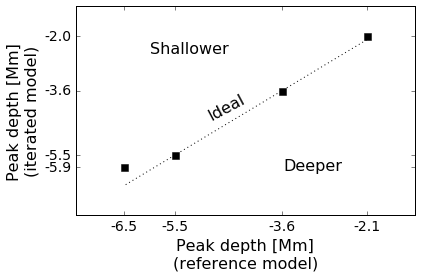

In [29]:
f=plt.figure()
f.set_size_inches(6,4)

peak_depths_ref = []
peak_depths_iter = []

for modelno,(codedir,datadir) in enumerate(zip(codedir_list,datadir_list)):
    
    coeff_files = sorted(fnmatch.filter(os.listdir(os.path.join(datadir,"update")),
                    "model_psi_[0-9][0-9].fits"))
    iterno = len(coeff_files)-1
    
    true_psi = fitsread(os.path.join(codedir,'true_psi.fits'))
    current_psi = fitsread(os.path.join(datadir,'update',
                    'model_psi_{:02d}.fits'.format(iterno)))
    current_psi = current_psi-current_psi[0,0]
    
    psi_max_row_index,psi_max_col_index = divmod(true_psi.argmax(),nx)
    curpsi_max_row_index,curpsi_max_col_index = divmod(current_psi.argmax(),nx)

    peak_depths_ref.append(z[true_psi[:,curpsi_max_col_index].argmax()])
    peak_depths_iter.append(z[current_psi[:,curpsi_max_col_index].argmax()])
    
plt.plot(peak_depths_ref,peak_depths_iter,marker='s',color='black',ls="None",ms=7)
plt.plot(peak_depths_ref,peak_depths_ref,color='black',ls="dotted")

plt.xticks(peak_depths_ref)
plt.yticks(peak_depths_iter)
    
plt.xlabel("Peak depth [Mm]\n(reference model)",fontsize=16)
plt.ylabel("Peak depth [Mm]\n(iterated model)",fontsize=16)
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
plt.tick_params(labelsize=14)
plt.margins(x=0.2,y=0.2)

plt.text(-6,-2.5,"Shallower",fontsize=16)
plt.text(-3.6,-6,"Deeper",fontsize=16)
plt.text(-5,-4,"Ideal",fontsize=16,rotation=28)

plt.tight_layout()

if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig("plots/peak_depths.eps")

## Misfit

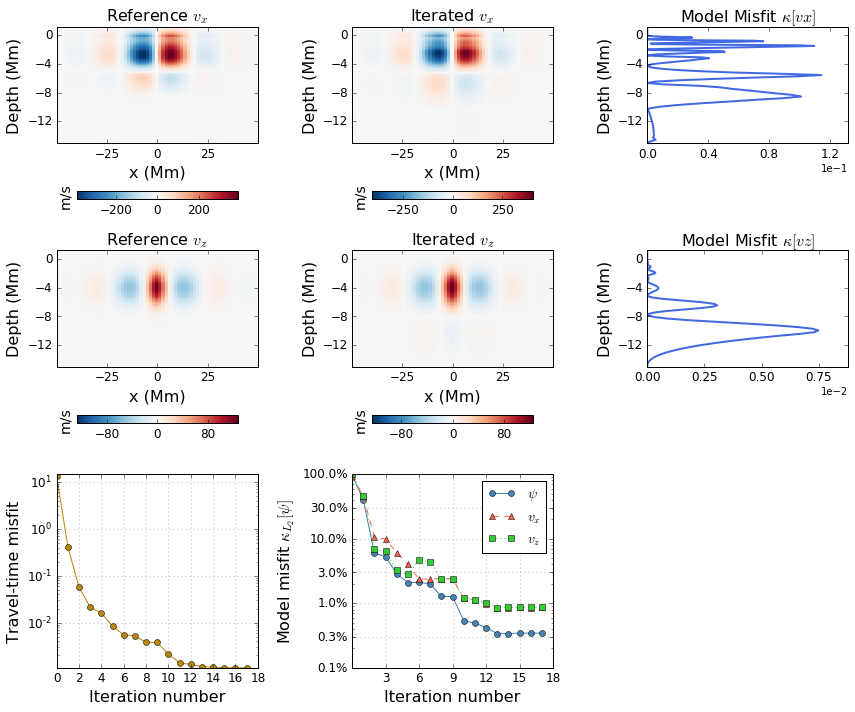

In [9]:
f=plt.figure()
f.set_size_inches(12,10)

datadir = datadir_list[1]
codedir = codedir_list[1]

coeff_files = sorted(fnmatch.filter(os.listdir(os.path.join(datadir,"update")),
                    "model_psi_[0-9][0-9].fits"))
iterno = len(coeff_files)-1

true_vx = fitsread(os.path.join(codedir,'true_vx.fits'))
true_vz = fitsread(os.path.join(codedir,'true_vz.fits'))
current_vx = fitsread(os.path.join(datadir,'update','vx_{:02d}.fits'.format(iterno)))
current_vz = fitsread(os.path.join(datadir,'update','vz_{:02d}.fits'.format(iterno)))

x_plot = np.append(x-dx/2,x[-1]+dx/2)

axlist = {}
cblist = {}
def add_subplot(sp_index,array,title=""):
    ax=plt.subplot(sp_index)
    array_max = abs(array).max()
    qm=ax.pcolormesh(x_plot,z,array,vmax=array_max,vmin=-array_max,cmap="RdBu_r",rasterized=True)
    cb=plt.colorbar(mappable=qm,orientation="horizontal",shrink=0.8,pad=0.25,ticks=ticker.MaxNLocator(5))
    plt.title(title,y=1.01,fontsize=16)
    ax.set_xlim(-50,50)
    ax.set_ylim(-15,z.max())
    ax.set_xlabel("x (Mm)",fontsize=16)
    ax.set_ylabel("Depth (Mm)",fontsize=16)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(4,prune="both"))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(5,prune="both"))
    ax.tick_params(axis='both',labelsize=12)
    axlist[sp_index]=ax
    cblist[sp_index]=cb

add_subplot(331,true_vx,title="Reference $v_x$")
add_subplot(332,current_vx,title="Iterated $v_x$")
add_subplot(333,true_vx,title="Reference $v_x$")
add_subplot(334,true_vz,title="Reference $v_z$")
add_subplot(335,current_vz,title="Iterated $v_z$")    
add_subplot(336,true_vz,title="Reference $v_z$")
    
for cb in cblist.values(): 
    cb.ax.set_ylabel("m/s",rotation=90,fontsize=14)
    cb.ax.tick_params(axis="x",labelsize=12)

misfitfiles=sorted([os.path.join(datadir,"update",f) for f in 
                    fnmatch.filter(os.listdir(os.path.join(datadir,"update")),
                                   'misfit_[0-9][0-9]')])

total_misfit = np.zeros(len(misfitfiles))
for fileno,misfitfile in enumerate(misfitfiles):
    total_misfit[fileno] = np.sum(np.loadtxt(misfitfile,usecols=[2]))

    
axlist[337]=plt.subplot(337)
plotdict = dict(color='darkgoldenrod',marker='o',ls='solid',zorder=1)
plt.semilogy(range(len(misfitfiles)),total_misfit,**plotdict)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylabel('Travel-time misfit',fontsize=16)
plt.xlabel("Iteration number",fontsize=16)
plt.margins(y=0.1)
plt.grid(color="0.5")

axlist[338]=plt.subplot(338)
with np.load(os.path.join(datadir,'true_psi_coeffs.npz')) as f:
    tz = f['tz']
    cz_top = f['cz_top']
    cz_true = f['cz_top']+f['cz_bot']
    kz = f['kz']

psi_true = interpolate.splev(z,(tz,cz_true,kz),ext=1)

psi_norm = integrate.simps(psi_true**2,x=z)
vz_norm = integrate.simps(c_sound**2*psi_true**2,x=z)
vx_norm = integrate.simps(1/rho**2*ddz(rho*c_sound*psi_true)**2,x=z)

misfit_psi = []
misfit_vx = []
misfit_vz = []

for iterno in xrange(len(misfitfiles)):
    with np.load(os.path.join(datadir,'update',
        'model_psi_{:02d}_coeffs.npz'.format(iterno))) as f:
        cz_model = f['z'] + cz_top
        psi_model = interpolate.splev(z,(tz,cz_model,kz),ext=1)

    misfit_psi_i = integrate.simps((psi_true-psi_model)**2,x=z)/psi_norm
    misfit_psi.append(misfit_psi_i)

    misfit_vz_i = integrate.simps(c_sound**2*(psi_true-psi_model)**2,x=z)/vz_norm
    misfit_vz.append(misfit_vz_i)

    misfit_vx_i = integrate.simps(1/rho**2*ddz(rho*c_sound*(psi_true-psi_model))**2,x=z)/vx_norm
    misfit_vx.append(misfit_vx_i)

axlist[338].semilogy(misfit_psi,linestyle='solid',marker='o',label="$\psi$",color='steelblue',zorder=1)
axlist[338].semilogy(misfit_vx,linestyle='dashed',marker='^',label="$v_x$",color='tomato',zorder=1)
axlist[338].semilogy(misfit_vz,linestyle='dotted',marker='s',label="$v_z$",color='limegreen',zorder=1)

plt.gca().yaxis.set_major_locator(ticker.LogLocator(subs=[1,3]))
def percent(y,position):
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(percent))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=8,integer=True,prune="lower"))
plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylabel(r"Model misfit $\kappa_{L_2}[\psi]$",fontsize=16)
plt.xlabel("Iteration number",fontsize=16)

plt.grid(color="0.5");
plt.legend(loc="best",fontsize=14);

with np.load(os.path.join(datadir,'update',
    'model_psi_{:02d}_coeffs.npz'.format(len(misfitfiles)-1))) as f:
    cz_model = f['z'] + cz_top
    psi_model = interpolate.splev(z,(tz,cz_model,kz),ext=1)

misfit_vz_scale = ((psi_true*c_sound).max())**2
misfit_vz = (psi_true-psi_model)**2*c_sound**2

misfit_vx_scale = ((ddz(rho*c_sound*psi_true)/rho).max())**2
misfit_vx = (ddz(rho*c_sound*(psi_true-psi_model))**2)/rho**2

axlist[333].cla()
axlist[336].cla()

axlist[333].set_rasterized(False)
axlist[333].plot(misfit_vx/misfit_vx_scale,z,color="royalblue",lw=2,zorder=1)
axlist[333].set_ylim(axlist[332].set_ylim())
axlist[333].yaxis.set_major_locator(axlist[332].yaxis.get_major_locator())
axlist[333].xaxis.set_major_locator(ticker.MaxNLocator(4))
axlist[333].ticklabel_format(axis="x",style="sci",scilimits=(0,0))
axlist[333].set_title(r"Model Misfit $\kappa[vx]$",fontsize=16)
axlist[333].set_xlim(0,axlist[333].get_xlim()[1]*1.1)
axlist[333].set_ylabel("Depth (Mm)",fontsize=16)

axlist[336].set_rasterized(False)
axlist[336].plot(misfit_vz/misfit_vz_scale,z,color="royalblue",lw=2)
axlist[336].set_ylim(axlist[335].set_ylim())
axlist[336].yaxis.set_major_locator(axlist[335].yaxis.get_major_locator())
axlist[336].xaxis.set_major_locator(ticker.MaxNLocator(4))
axlist[336].ticklabel_format(axis="x",style="sci",scilimits=(0,0))
axlist[336].set_title(r"Model Misfit $\kappa[vz]$",fontsize=16)
axlist[336].set_xlim(0,axlist[336].get_xlim()[1]*1.1)
axlist[336].set_ylabel("Depth (Mm)",fontsize=16)

plt.tight_layout()

cblist[333].ax.set_visible(False)
cblist[336].ax.set_visible(False)

if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig("plots/true_iter_vel_misfits.eps")